This notebook runs a defined pipeline on HCP subjects, on the Cedars-Sinai cluster.
After it is done preprocessing all subjects, it runs the leave-one-family-out personality prediction.

# Load libraries & helper functions

In [1]:
from helpers import *
%matplotlib inline

# Declare parameters

In [2]:
config.DATADIR                 = '/scratch/duboisjx/data/HCP/MRI'
# fMRI runs
session                        = 'REST1'
fmriRuns                       = ['rfMRI_'+session+'_LR','rfMRI_'+session+'_RL']
# use volume or surface data
config.fmriFileTemplate        = '#fMRIrun#.nii.gz'
#config.fmriFileTemplate        = '#fMRIrun#_Atlas.dtseries.nii'
#config.fmriFileTemplate        = '#fMRIrun#_Atlas_MSMAll.dtseries.nii'
config.melodicFolder           = op.join('#fMRIrun#_hp2000.ica','filtered_func_data.ica') #the code #fMRIrun# will be replaced
config.movementRelativeRMSFile = 'Movement_RelativeRMS.txt'
config.movementRegressorsFile  = 'Movement_Regressors_dt.txt'
# parcellation for FC matrix
config.parcellationName        = 'shen2013'
config.parcellationFile        = '/scratch/duboisjx/data/parcellations/shenetal_neuroimage2013_new/shen_2mm_268_parcellation.nii.gz'
config.nParcels                = 268
config.maskParcelswithAll      = True
config.maskParcelswithGM       = False
# subject selection parameters
config.behavFile               = '/scratch/duboisjx/data/HCP/neuropsych/unrestricted_luckydjuju_6_7_2017_0_44_41.csv'
config.RbehavFile              = '/scratch/duboisjx/data/HCP/neuropsych/RESTRICTED_luckydjuju_8_22_2017_11_13_18.csv'

config.release                 = 'all' #'all+MEG2'
config.outScore                = 'PMAT24_A_CR'
# submit jobs with sge
config.queue        = True

# do not alter the following lines
if config.maskParcelswithGM:
    config.parcellationName = config.parcellationName + '_GM'
tmp = config.fmriFileTemplate.split('.')
if tmp[1]=='nii':
    config.isCifti = False
elif tmp[1]=='dtseries':
    config.isCifti = True
else:
    print 'unknown file extension'

config.preWhitening            = False

# whether to use memmapping (which involves unzipping)
# deprecated
config.useMemMap               = False


# Subject selection

In [3]:
Udf = pd.read_csv(config.behavFile)
Rdf = pd.read_csv(config.RbehavFile)
# merge unrestricted and restricted
df = pd.merge(Udf,Rdf,how='inner')

# keep only variables of interest
df = df[['Subject','Release','Gender','Family_ID','Father_ID','Mother_ID','Age_in_Yrs','FS_BrainSeg_Vol','fMRI_3T_ReconVrs',
        '3T_RS-fMRI_PctCompl','PMAT_Compl','NEO-FFI_Compl','MMSE_Compl',
        'PMAT24_A_CR','MMSE_Score','NEOFAC_O','NEOFAC_C','NEOFAC_E','NEOFAC_A','NEOFAC_N',
        'NEORAW_01','NEORAW_02','NEORAW_03','NEORAW_04','NEORAW_05','NEORAW_06','NEORAW_07','NEORAW_08','NEORAW_09','NEORAW_10',
        'NEORAW_11','NEORAW_12','NEORAW_13','NEORAW_14','NEORAW_15','NEORAW_16','NEORAW_17','NEORAW_18','NEORAW_19','NEORAW_20',
        'NEORAW_21','NEORAW_22','NEORAW_23','NEORAW_24','NEORAW_25','NEORAW_26','NEORAW_27','NEORAW_28','NEORAW_29','NEORAW_30',
        'NEORAW_31','NEORAW_32','NEORAW_33','NEORAW_34','NEORAW_35','NEORAW_36','NEORAW_37','NEORAW_38','NEORAW_39','NEORAW_40',
        'NEORAW_41','NEORAW_42','NEORAW_43','NEORAW_44','NEORAW_45','NEORAW_46','NEORAW_47','NEORAW_48','NEORAW_49','NEORAW_50',
        'NEORAW_51','NEORAW_52','NEORAW_53','NEORAW_54','NEORAW_55','NEORAW_56','NEORAW_57','NEORAW_58','NEORAW_59','NEORAW_60',
        'PicSeq_Unadj','CardSort_Unadj','Flanker_Unadj','ReadEng_Unadj',
        'ProcSpeed_Unadj','DDisc_AUC_200','DDisc_AUC_40K','VSPLOT_TC','SCPT_SEN','SCPT_SPEC',
        'IWRD_TOT','ListSort_Unadj','PicVocab_Unadj','ER40_CR','AngAffect_Unadj',
        'AngHostil_Unadj','AngAggr_Unadj','FearAffect_Unadj','FearSomat_Unadj','Sadness_Unadj',
        'LifeSatisf_Unadj','MeanPurp_Unadj','PosAffect_Unadj','Friendship_Unadj','Loneliness_Unadj',
        'PercHostil_Unadj','PercReject_Unadj','EmotSupp_Unadj','InstruSupp_Unadj',
        'PercStress_Unadj','SelfEff_Unadj']]

# select subjects according to release
if config.release == 'Q2':
    keepSub = (df['Release'] == 'Q2') | (df['Release'] == 'Q1')
elif config.release == 'S500':
    keepSub = (df['Release'] == 'Q3') | (df['Release'] == 'S500')
elif config.release == 'Q2+S500':
    keepSub = (df['Release'] == 'Q2') | (df['Release'] == 'Q1') | (df['Release'] == 'Q3') | (df['Release'] == 'S500')
elif config.release == 'S900':
    keepSub = (df['Release'] == 'S900')
elif config.release == 'S1200':
    keepSub = (df['Release'] == 'S1200')
elif config.release == 'all':
    keepSub = ((df['Release'] == 'Q1') | (df['Release'] == 'Q2') | (df['Release'] == 'Q3') 
           | (df['Release'] == 'S500') | (df['Release'] == 'S900') | (df['Release'] == 'S1200'))
elif config.release == 'all+MEG2':
    keepSub = ((df['Release'] == 'Q1') | (df['Release'] == 'Q2') | (df['Release'] == 'Q3') 
           | (df['Release'] == 'S500') | (df['Release'] == 'S900') | (df['Release'] == 'S1200') 
           | (df['Release'] == 'MEG2'))
else:
    sys.exit("Invalid release code")
print 'Selected {} subjects for release {}'.format(np.sum(keepSub),config.release)

# select subjects that have completed all fMRI
keepSub = keepSub & (
    (df['3T_RS-fMRI_PctCompl']==100) & 
    (df['PMAT_Compl']==True) &
    (df['NEO-FFI_Compl']==True)&
    (df['MMSE_Compl']==True))
print 'Kept {} subjects with complete datasets'.format(np.sum(keepSub))

# check if either of the two subjects recommended for exclusion by HCP are still present
keepSub = keepSub & (
    ~df['Subject'].isin([209733,528446]))

# remove subject missing item scores for NEO
keepSub = keepSub & (
    ~df['Subject'].isin([131924]))

# FURTHER EXCLUSIONARY CRITERIA
# --> MMSE <26 excluded
keepSub    = np.logical_and(keepSub,df['MMSE_Score']>=26)
print 'Kept {} subjects after MMSE<26 exclusion criterion'.format(np.sum(keepSub))

# PRUNE df 
df        = df[keepSub]
# reindex
df.index  = range(df.shape[0])

# Exclusion of high-motion subjects
# exclude subjects with >0.14 frame-to-frame head motion estimate averged across both rest runs (arbitrary threshold as in Finn et al 2015)
RelRMSMean = np.zeros([len(df['Subject']), len(fmriRuns)],dtype=np.float32)
FDsum      = np.zeros([len(df['Subject']), len(fmriRuns)],dtype=np.float32)
keepSub    = np.zeros((len(df['Subject'])),dtype=np.bool_)
iSub=0
excluded = list()
for subject in df['Subject']:
    config.subject=str(subject)
    # RelRMSMean
    i=0
    for config.fmriRun in fmriRuns:
        RelRMSMeanFile = op.join(buildpath(), 'Movement_RelativeRMS_mean.txt')
        if op.isfile(RelRMSMeanFile):
            with open(RelRMSMeanFile,'r') as tmp:
                RelRMSMean[iSub,i] = float(tmp.read())
        else:
            excluded.append(config.subject)
            #print RelRMSMeanFile+' File missing'
            break
        i=i+1
    if i==len(fmriRuns): # all RelRMSMeanFile exist
        if np.mean(RelRMSMean[iSub,:]) > 0.14:
            excluded.append(config.subject)
        else:
            keepSub[iSub]=True
    # total framewise displacement
    i=0
    for config.fmriRun in fmriRuns:
        FDsumFile = op.join(buildpath(), 'FD_sum.txt')
        if not op.isfile(FDsumFile):
            motionFile = op.join(buildpath(), config.movementRegressorsFile)
            if op.isfile(motionFile):
                dmotpars = np.abs(np.genfromtxt(motionFile)[:,6:]) #derivatives
                headradius=50 #50mm as in Powers et al. 2012
                disp=dmotpars.copy()
                disp[:,3:]=np.pi*headradius*2*(disp[:,3:]/360)
                thisFDsum=np.sum(np.sum(disp,1),0)
                with open(FDsumFile,'w') as tmp:
                    tmp.write(str(thisFDsum))
            else:
                break
        with open(FDsumFile,'r') as tmp:
            FDsum[iSub,i] = float(tmp.read())
        i=i+1
    iSub=iSub+1

# add RelRMSMean and FDsum to the dataframe
df['RelRMSMean'] = np.mean(RelRMSMean,axis=1)
df['FDsum']      = np.mean(FDsum,axis=1)

# PRUNE df 
df        = df[keepSub]
# reindex
df.index  = range(df.shape[0])

print 'Keeping {} subjects [{} M] after excluding high motion'.format(len(df['Subject']),sum([g=='M' for g in df['Gender']]))
print 'Age range is', np.min(df['Age_in_Yrs']), '-', np.max(df['Age_in_Yrs'])

# replace labeled columns with dummies
df['Gender'].replace(['F','M'],[1,2],inplace=True)
df['fMRI_3T_ReconVrs'].replace(['r177','r177 r227','r227'],[1,2,3],inplace=True)

Selected 1191 subjects for release all
Kept 984 subjects with complete datasets
Kept 982 subjects after MMSE<26 exclusion criterion
Keeping 910 subjects [429 M] after excluding high motion
Age range is 22 - 37


In [9]:
# RECOMPUTE NEO FACTORS from items
# http://darkwing.uoregon.edu/~gsaucier/NEO-FFI%20subcomponent%20norms%20and%20scoring.htm
# and Compute Cronbach's Alpha
def CronbachAlpha(itemScores):
    itemVars   = itemScores.var(axis=1, ddof=1)
    totScores  = itemScores.sum(axis=0)
    nItems     = itemScores.shape[0]
    return nItems / (nItems-1.) * (1 - itemVars.sum() / totScores.var(ddof=1))
# make copies of relevant variables
NEO = df[['NEOFAC_O','NEOFAC_C','NEOFAC_E','NEOFAC_A','NEOFAC_N',
        'NEORAW_01','NEORAW_02','NEORAW_03','NEORAW_04','NEORAW_05','NEORAW_06','NEORAW_07','NEORAW_08','NEORAW_09','NEORAW_10',
        'NEORAW_11','NEORAW_12','NEORAW_13','NEORAW_14','NEORAW_15','NEORAW_16','NEORAW_17','NEORAW_18','NEORAW_19','NEORAW_20',
        'NEORAW_21','NEORAW_22','NEORAW_23','NEORAW_24','NEORAW_25','NEORAW_26','NEORAW_27','NEORAW_28','NEORAW_29','NEORAW_30',
        'NEORAW_31','NEORAW_32','NEORAW_33','NEORAW_34','NEORAW_35','NEORAW_36','NEORAW_37','NEORAW_38','NEORAW_39','NEORAW_40',
        'NEORAW_41','NEORAW_42','NEORAW_43','NEORAW_44','NEORAW_45','NEORAW_46','NEORAW_47','NEORAW_48','NEORAW_49','NEORAW_50',
        'NEORAW_51','NEORAW_52','NEORAW_53','NEORAW_54','NEORAW_55','NEORAW_56','NEORAW_57','NEORAW_58','NEORAW_59','NEORAW_60',
        ]].copy()
Calphas  = list();CalphasM = list();CalphasF = list();diff     = list()

# scoring = [ 
#     # O = (13, 23*, 43 // 48*, 53, 58 // 3*, 8*, 18*, 38*)
#     {'13':'n', '23':'r', '43':'n', #aesthetic interests
#    '48':'r', '53':'n', '58':'n', #intellectual interests
#    '03':'r', '08':'r', '18':'r', '38':'r'}, # unconventionality
#     # C = (5, 10, 15*, 30*, 55* // 25, 35, 60 // 20, 40, 45*, 50)
#     {'05':'n', '10':'n', '15':'r', '30':'r', '55':'r', # orderliness
#    '25':'n', '35':'n', '60':'n', # goal-striving
#    '20':'n', '40':'n', '45':'r', '50':'n'}, # dependability
#     # E = (7, 12*, 37, 42* // 2, 17, 27*, 57* // 22, 32, 47, 52)
#     {'07':'n', '12':'r', '37':'n', '42':'r', # positive affect
#    '02':'n', '17':'n', '27':'r', '57':'r', # sociability
#    '22':'n', '32':'n', '47':'n', '52':'n'}, # activity
#     # A = (9*, 14*, 19, 24*, 29*, 44*, 54*, 59* // 4, 34, 39*, 49)
#     {'09':'r', '14':'r', '19':'n', '24':'r', '29':'r', '44':'r', '54':'r', '59':'r', #nonantagonistic orientation
#    '04':'n', '34':'n', '39':'r', '49':'n'}, # prosocial orientation
#     # N = (1*, 11, 16*, 31*, 46* // 6, 21, 26, 36, 41, 51, 56)
#     {'01':'r', '11':'n', '16':'r', '31':'r', '46':'r', # negative affect
#    '06':'n', '21':'n', '26':'n', '36':'n', '41':'n', '51':'n', '56':'n'} # self-reproach
#     ]

scoring = [ 
    {'13':'n', '23':'r', '43':'n', #aesthetic interests
    '48':'r', '53':'n', '58':'n', #intellectual interests
    '03':'r', '08':'r', '18':'r', '38':'r', # unconventionality
    '28':'n', '33':'r'},#??
    {'05':'n', '10':'n', '15':'r', '30':'r', '55':'r', # orderliness
    '25':'n', '35':'n', '60':'n', # goal-striving
    '20':'n', '40':'n', '45':'r', '50':'n'}, # dependability
    {'07':'n', '12':'r', '37':'n', '42':'r', # positive affect
   '02':'n', '17':'n', '27':'r', '57':'r', # sociability
   '22':'n', '32':'n', '47':'n', '52':'n'}, # activity
    {'09':'r', '14':'r', '19':'n', '24':'r', '29':'r', '44':'r', '54':'r', '59':'r', #nonantagonistic orientation
   '04':'n', '34':'n', '39':'r', '49':'n'}, # prosocial orientation
    {'01':'r', '11':'n', '16':'r', '31':'r', '46':'r', # negative affect
   '06':'n', '21':'n', '26':'n', '36':'n', '41':'n', '51':'n', '56':'n'} # self-reproach
    ]

factors = ['O','C','E','A','N']
for iFac,factor in enumerate(factors):
    this       = np.zeros(df.shape[0])
    itemScores = np.zeros((len(scoring[iFac].keys()),df.shape[0]))
    keyCtr = -1
    for key in scoring[iFac].keys():
        if scoring[iFac][key]=='n':
            NEO['NEORAW_'+key].replace(['SD','D','N','A','SA'],[0,1,2,3,4],inplace=True)
        else:
            NEO['NEORAW_'+key].replace(['SD','D','N','A','SA'],[4,3,2,1,0],inplace=True)
        this = this + NEO['NEORAW_'+key]
        keyCtr += 1
        itemScores[keyCtr,:] = np.ravel(NEO['NEORAW_'+key])
    df['NEOFAC_'+factor+'_calc']=this
    Calphas.append(CronbachAlpha(itemScores))
    CalphasF.append(CronbachAlpha(itemScores[:,np.ravel(df['Gender']==1)]))
    CalphasM.append(CronbachAlpha(itemScores[:,np.ravel(df['Gender']==2)]))
    diff.append(np.sum(np.abs(df['NEOFAC_'+factor]-df['NEOFAC_'+factor+'_calc'])))

print 'diffO={0:d}, diffC={1:d}, diffE={2:d}, diffA={3:d}, diffN={4:d}'.format(
    np.int(diff[0]),np.int(diff[1]),np.int(diff[2]),np.int(diff[3]),np.int(diff[4]))
print 'Cronbach''s alpha   O={0:.3f}, C={1:.3f}, E={2:.3f}, A={3:.3f}, N={4:.3f}'.format(
    Calphas[0],Calphas[1],Calphas[2],Calphas[3],Calphas[4])
print 'Cronbach''s alpha M O={0:.3f}, C={1:.3f}, E={2:.3f}, A={3:.3f}, N={4:.3f}'.format(
    CalphasM[0],CalphasM[1],CalphasM[2],CalphasM[3],CalphasM[4])
print 'Cronbach''s alpha F O={0:.3f}, C={1:.3f}, E={2:.3f}, A={3:.3f}, N={4:.3f}'.format(
    CalphasF[0],CalphasF[1],CalphasF[2],CalphasF[3],CalphasF[4])

# # correct scores
df['NEOFAC_A_corr']  = df['NEOFAC_A_calc']
NEO['NEOFAC_A_corr'] = df['NEOFAC_A_calc']


diffO=0, diffC=0, diffE=0, diffA=2028, diffN=0
Cronbachs alpha   O=0.754, C=0.814, E=0.779, A=0.759, N=0.844
Cronbachs alpha M O=0.758, C=0.808, E=0.780, A=0.754, N=0.863
Cronbachs alpha F O=0.755, C=0.818, E=0.782, A=0.740, N=0.824


In [10]:
scoreL = ['NEOFAC_O', 'NEOFAC_C', 'NEOFAC_E', 'NEOFAC_A_corr', 'NEOFAC_N']
scoreMat = None
for score in scoreL:
    # add to conMat
    if scoreMat is None:
        scoreMat = np.ravel(df[score])
    else:
        scoreMat = np.vstack((scoreMat,np.ravel(df[score])))

NEO[scoreL].to_csv('./factorScores.csv')
        
itemL  = [
        'NEORAW_01','NEORAW_02','NEORAW_03','NEORAW_04','NEORAW_05','NEORAW_06','NEORAW_07','NEORAW_08','NEORAW_09','NEORAW_10',
        'NEORAW_11','NEORAW_12','NEORAW_13','NEORAW_14','NEORAW_15','NEORAW_16','NEORAW_17','NEORAW_18','NEORAW_19','NEORAW_20',
        'NEORAW_21','NEORAW_22','NEORAW_23','NEORAW_24','NEORAW_25','NEORAW_26','NEORAW_27','NEORAW_28','NEORAW_29','NEORAW_30',
        'NEORAW_31','NEORAW_32','NEORAW_33','NEORAW_34','NEORAW_35','NEORAW_36','NEORAW_37','NEORAW_38','NEORAW_39','NEORAW_40',
        'NEORAW_41','NEORAW_42','NEORAW_43','NEORAW_44','NEORAW_45','NEORAW_46','NEORAW_47','NEORAW_48','NEORAW_49','NEORAW_50',
        'NEORAW_51','NEORAW_52','NEORAW_53','NEORAW_54','NEORAW_55','NEORAW_56','NEORAW_57','NEORAW_58','NEORAW_59','NEORAW_60',
        ]        
itemMat = None
for item in itemL:
    if itemMat is None:
        itemMat  = np.ravel(NEO[item])
    else:
        itemMat = np.vstack((itemMat,np.ravel(NEO[item])))

NEO[itemL].to_csv('./itemScores.csv')

rbX            = RobustScaler()
scoreMatScaled = rbX.fit_transform(scoreMat.T)

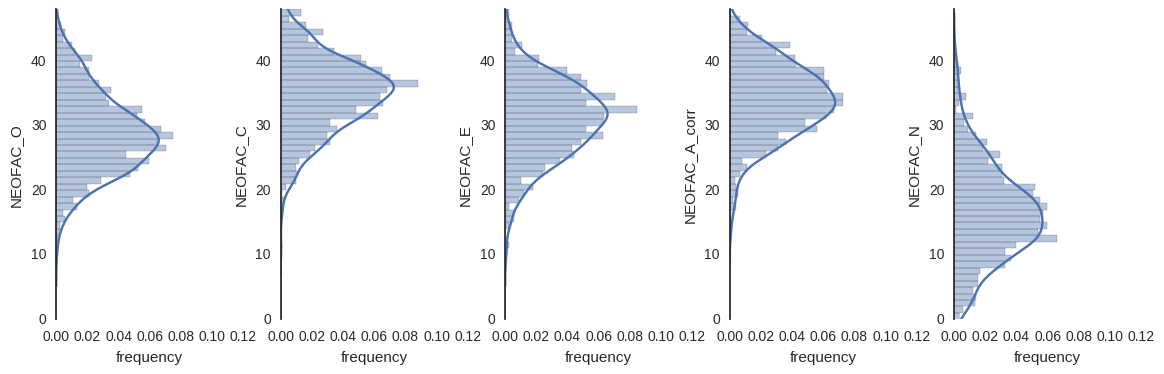

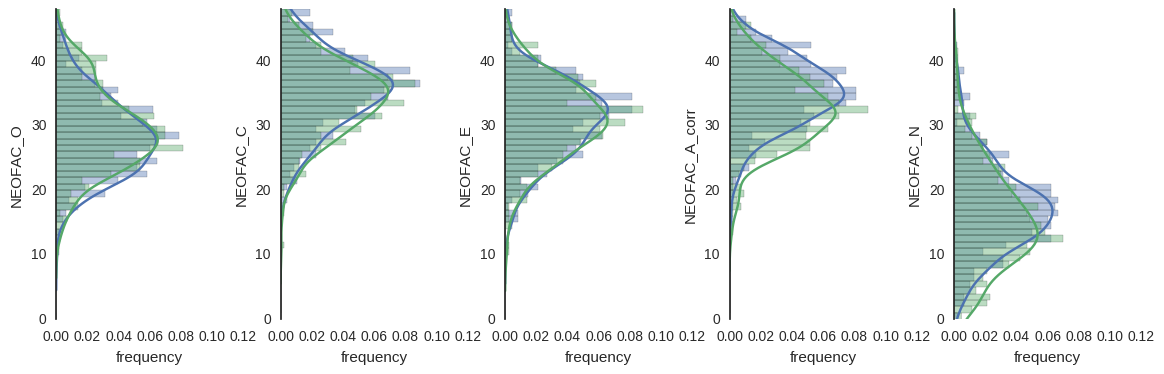

In [194]:
fig = plt.figure(figsize=(14,4))
for iScore,score in enumerate(scoreL):
    ax = fig.add_subplot(1,len(scoreL),iScore+1)
    sns.distplot(scoreMat[iScore,:],bins=range(49), vertical=True)
    ax.set(ylim=(0, 48), xlim=(0, .12), ylabel=score,xlabel="frequency")
    sns.despine(left=False, bottom=True)
    
fig = plt.figure(figsize=(14,4))
for iScore,score in enumerate(scoreL):
    ax = fig.add_subplot(1,len(scoreL),iScore+1)
    sns.distplot(scoreMat[iScore,np.ravel(df['Gender'])==1], vertical=True, bins=range(49), ax=ax, kde=True)
    sns.distplot(scoreMat[iScore,np.ravel(df['Gender'])==2], vertical=True, bins=range(49), ax=ax, kde=True)
    ax.set(ylim=(0, 48), xlim=(0, .12), ylabel=score,xlabel="frequency")
    sns.despine(left=False, bottom=True)

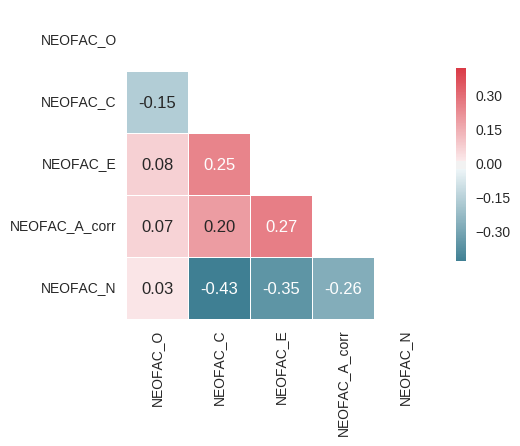

In [11]:
thisdf = df[scoreL]
corr = thisdf.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig = plt.figure(figsize=(5,5));
sns.set(style="white")
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".2f", mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

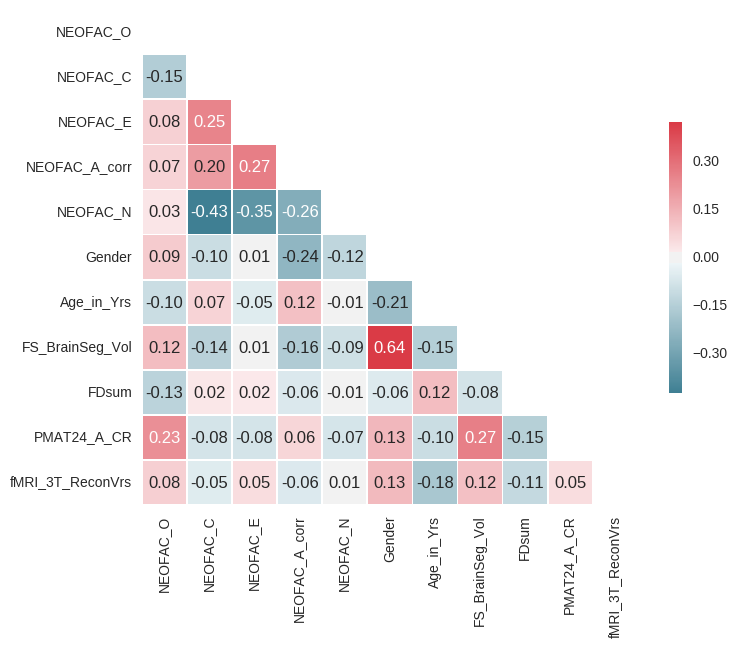

In [12]:
SML    = ['NEOFAC_O', 'NEOFAC_C', 'NEOFAC_E', 'NEOFAC_A_corr', 'NEOFAC_N',
          'Gender','Age_in_Yrs','FS_BrainSeg_Vol','FDsum','PMAT24_A_CR','fMRI_3T_ReconVrs']
thisdf = df[SML]

corr = thisdf.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(style="white")
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 7))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".2f", mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# for i,I in enumerate(SML):
#     print ' '
#     for j,J in enumerate(SML):
#         if j>i:
#             print 'corr ({0:s} ,{1:s}): rho = {2:.4f}, p = {3:.3E}'.format(
#                 I,J,stats.pearsonr(np.ravel(df[I]),np.ravel(df[J]))[0],stats.pearsonr(np.ravel(df[I]),np.ravel(df[J]))[1])


## Detecting multivariate outliers: Use a robust variant of the Mahalanobis distance

(910, 5)


,Subject,Release,Gender,Family_ID,Father_ID,Mother_ID,Age_in_Yrs,FS_BrainSeg_Vol,fMRI_3T_ReconVrs,3T_RS-fMRI_PctCompl,...,PercStress_Unadj,SelfEff_Unadj,RelRMSMean,FDsum,NEOFAC_O_calc,NEOFAC_C_calc,NEOFAC_E_calc,NEOFAC_A_calc,NEOFAC_N_calc,NEOFAC_A_corr
48,111716,Q3,1,52076_81940,81940,52076,32,1059845.0,3,100.0,...,47.8,63.3,0.093418,208.643433,44.0,42.0,34.0,15.0,14.0,15.0
80,119025,S1200,2,56034_85855,85855,56034,29,1222528.0,3,100.0,...,32.2,60.3,0.072997,165.677826,27.0,33.0,11.0,29.0,1.0,29.0
132,131722,S500,1,52364_82227,82227,52364,28,1207256.0,3,100.0,...,69.3,39.1,0.107543,244.485718,37.0,28.0,25.0,42.0,39.0,42.0
236,156233,Q3,1,51416_52851_81281,81281,52851,25,1207356.0,1,100.0,...,25.9,68.4,0.100742,226.756042,32.0,48.0,38.0,20.0,4.0,20.0
491,268749,S900,2,56066_85887,85887,56066,29,1413458.0,3,100.0,...,37.6,68.4,0.091029,194.415070,28.0,39.0,37.0,17.0,2.0,17.0
550,361941,Q3,2,52049_81913,81913,52049,27,1302020.0,3,100.0,...,64.0,31.6,0.055657,127.093155,31.0,35.0,20.0,40.0,40.0,40.0
585,415837,S500,1,52450_82293,82293,52450,23,1204213.0,3,100.0,...,40.1,50.3,0.066092,153.124496,17.0,31.0,15.0,27.0,6.0,27.0
601,456346,S900,1,52194_82057,82057,52194,22,1128836.0,3,100.0,...,49.1,36.9,0.120396,269.742065,23.0,18.0,39.0,42.0,22.0,42.0
633,529549,S900,1,54644_84466,84466,54644,26,1070772.0,3,100.0,...,51.8,56.9,0.067689,163.927475,22.0,46.0,32.0,17.0,16.0,17.0
731,677766,S900,2,51864_81728,81728,51864,29,1181458.0,3,100.0,...,51.1,63.1,0.109185,227.192719,20.0,20.0,24.0,13.0,37.0,13.0


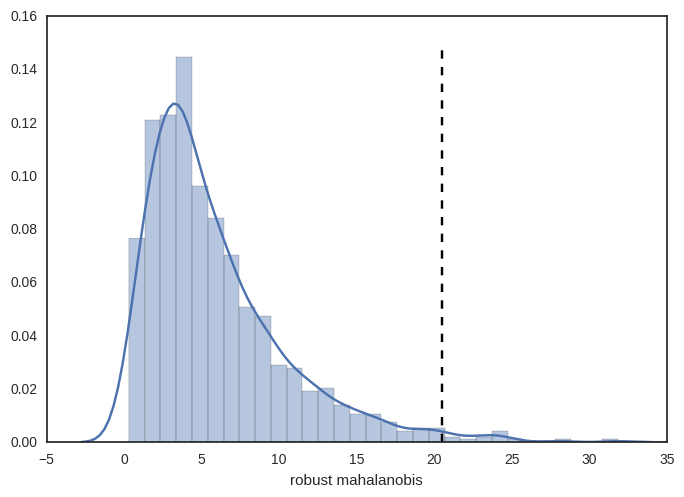

In [22]:
from sklearn.covariance import MinCovDet
# fit a Minimum Covariance Determinant (MCD) robust estimator to data
robust_cov   = MinCovDet(assume_centered=True,support_fraction=.75).fit(scoreMatScaled)
print scoreMatScaled.shape
robust_mahal = robust_cov.mahalanobis(scoreMatScaled - robust_cov.location_)

outlierThr = stats.chi2.isf(q=0.001,df=scoreMatScaled.shape[1])

sns.distplot(robust_mahal)
plt.plot([outlierThr, outlierThr],[0., .15],"k--")
plt.xlabel('robust mahalanobis')
isOut = (robust_mahal>=outlierThr)

df[isOut]




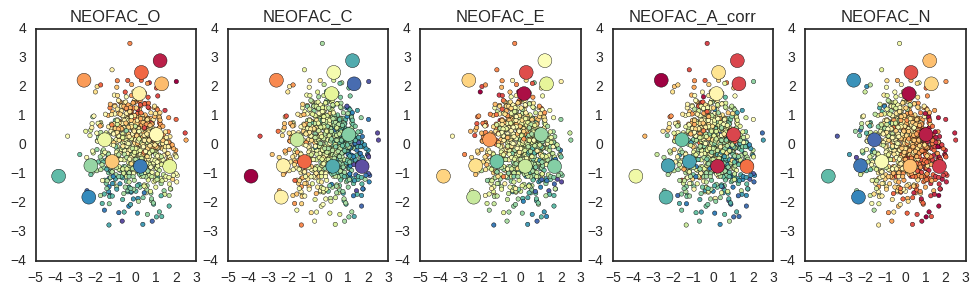

In [55]:
projections = np.asarray([
    [-0.890856,0.444756],
    [0.351407,0.165693],
    [0.063238,-0.124448],
    [-0.242897,0.230072],
    [0.584905,0.749166],
    [0.301598,0.164326],
    [1.176265,0.590151],
    [1.277233,-0.491905],
    [0.151160,-0.457088],
    [-0.260254,-2.044852],
    [0.018842,0.243177],
    [-0.970727,-0.583910],
    [1.360571,-0.516336],
    [1.115639,-0.102322],
    [0.332934,-0.363791],
    [0.249419,0.075442],
    [1.090452,0.317468],
    [-1.240303,-0.442472],
    [-0.622011,0.275633],
    [-0.504416,1.478930],
    [-0.922887,1.235686],
    [0.992800,-0.323308],
    [1.151456,-0.087622],
    [-1.238950,0.473205],
    [-1.881087,0.749139],
    [-0.489636,0.866215],
    [0.189491,0.727974],
    [-2.242237,-1.017777],
    [-0.842532,-0.742148],
    [-0.613240,-0.060814],
    [-0.102565,-0.501922],
    [0.146133,-0.413731],
    [-0.135595,1.450152],
    [0.941728,0.981439],
    [0.437474,1.415502],
    [-0.737114,-1.079181],
    [-0.397968,-0.003804],
    [1.173012,-0.352026],
    [-1.665058,-0.223515],
    [-2.089784,0.997932],
    [0.221646,1.535753],
    [0.776768,-0.129025],
    [1.020938,0.080284],
    [0.666826,-1.045121],
    [1.287833,-0.675317],
    [-0.285490,-0.174144],
    [0.226470,0.967872],
    [-0.965369,-0.776935],
    [0.230412,-0.730722],
    [0.888137,-2.033804],
    [-0.954870,-1.443283],
    [-0.194018,0.328611],
    [-0.832489,0.166384],
    [-0.532031,-0.755736],
    [0.370214,0.061352],
    [0.687285,0.198510],
    [-0.233125,0.850248],
    [1.195140,-0.429440],
    [-0.419642,0.296146],
    [0.102537,-0.926534],
    [0.613175,1.304567],
    [-1.201022,-0.928922],
    [-0.572459,0.850331],
    [-0.796509,-0.286843],
    [-0.168372,0.301185],
    [0.300235,0.691230],
    [-0.171349,0.561977],
    [-0.213997,0.701297],
    [1.310686,-1.229809],
    [-1.108112,0.411101],
    [-0.093846,1.837143],
    [0.775441,0.438244],
    [-0.570013,-0.316427],
    [-1.301634,-0.656606],
    [-0.171567,0.382134],
    [0.101574,-0.508541],
    [0.112654,-0.871806],
    [0.274857,2.226595],
    [-2.251161,0.508236],
    [-1.404733,0.347938],
    [0.171585,1.768617],
    [-0.953508,-0.384261],
    [0.798207,-0.213600],
    [-0.457538,0.706798],
    [0.023649,-0.221747],
    [-0.017697,0.403169],
    [-1.339198,-2.752000],
    [0.544924,-0.381443],
    [-1.482763,0.419806],
    [-0.236303,0.640643],
    [0.067461,0.749426],
    [0.321352,0.997156],
    [0.075479,0.852538],
    [-1.445774,-1.496323],
    [0.333255,0.625732],
    [-1.161340,1.142206],
    [1.236962,0.714846],
    [0.133985,-1.936323],
    [-0.605412,0.885750],
    [-0.598677,-1.669023],
    [0.349127,0.015728],
    [-1.038299,-0.510423],
    [2.020817,2.184870],
    [0.771808,0.760083],
    [0.687849,-0.398986],
    [0.263404,0.768572],
    [1.349751,0.645493],
    [0.072678,-0.218669],
    [-0.605817,-0.965396],
    [-0.154259,0.395311],
    [0.198802,0.370418],
    [1.837621,-1.177675],
    [-0.362281,-0.850057],
    [-0.153133,0.595167],
    [0.618394,0.496575],
    [1.429323,-0.177544],
    [-0.064187,0.416028],
    [0.881185,-0.210472],
    [-0.852030,0.821038],
    [-0.281545,-0.860672],
    [0.206695,0.006398],
    [0.920932,0.502611],
    [0.420243,-1.643359],
    [-1.516384,1.060512],
    [-0.016117,0.647382],
    [0.903873,0.479239],
    [0.932709,1.338477],
    [-1.219567,0.719352],
    [0.368627,0.557592],
    [0.388898,-0.656937],
    [0.657546,1.278006],
    [1.077635,-0.999344],
    [-2.242499,-0.711071],
    [-1.165671,-1.323865],
    [-0.692992,1.019259],
    [-0.051307,-0.635425],
    [0.623507,-0.476006],
    [0.192062,-0.500927],
    [1.165228,-0.362452],
    [-0.019549,0.226552],
    [0.653976,-0.326489],
    [-0.463729,-0.044809],
    [1.170255,-0.871052],
    [0.187004,1.210143],
    [0.032549,-0.453403],
    [1.381260,-1.022439],
    [0.755824,0.454048],
    [-1.095997,-1.321902],
    [-1.661384,-1.218623],
    [0.539626,-0.930181],
    [-0.744302,0.278289],
    [-0.423542,-0.287667],
    [0.135655,0.561885],
    [0.255498,-0.127027],
    [-1.132287,0.711662],
    [-0.039067,0.900697],
    [-0.526455,0.192921],
    [0.578807,-2.386488],
    [-0.066729,0.115198],
    [0.350604,-2.730024],
    [-0.011807,0.509487],
    [-0.626049,0.209415],
    [0.527114,-0.234854],
    [-0.931469,-0.181668],
    [0.593001,-0.150045],
    [0.732629,-1.596890],
    [0.854632,0.406779],
    [-0.697060,0.526239],
    [1.629003,-0.534649],
    [0.634507,1.441153],
    [0.082466,0.174983],
    [0.235627,-0.991080],
    [0.007580,0.723119],
    [-1.676963,-2.010312],
    [-0.849769,-0.832503],
    [-0.057711,1.011172],
    [0.395848,-0.177920],
    [-1.024359,0.576550],
    [-0.053010,0.069380],
    [-0.913507,1.701447],
    [0.117142,0.761311],
    [-0.862827,1.092049],
    [1.106541,0.190832],
    [-0.244136,0.982724],
    [-0.365927,0.838708],
    [1.203384,1.112330],
    [-0.072385,0.795188],
    [-2.408942,-0.609509],
    [0.818725,0.407904],
    [-3.402645,0.306100],
    [-0.968740,-0.243480],
    [0.235446,0.014354],
    [0.578885,0.087573],
    [-0.300339,-0.096886],
    [0.566670,0.871046],
    [-0.568184,-0.181771],
    [0.525248,-0.348677],
    [-1.217278,0.023753],
    [-1.042106,1.331486],
    [1.260049,-1.746637],
    [-1.948505,0.410854],
    [-1.159771,-0.551068],
    [0.637168,-0.106493],
    [-0.183468,0.814458],
    [0.810400,-0.939341],
    [-0.983934,-1.023682],
    [0.904085,-0.085947],
    [-0.789557,-1.333485],
    [0.806456,0.359008],
    [-0.434273,0.908396],
    [0.647692,0.166961],
    [-2.434858,-1.572324],
    [-0.105279,-1.521021],
    [0.964208,0.432910],
    [0.805782,0.351055],
    [0.611170,1.645245],
    [0.320244,0.521323],
    [1.169323,0.957506],
    [-1.246552,0.592478],
    [-2.145312,0.970642],
    [0.415976,0.332326],
    [-0.130280,0.742171],
    [1.040085,0.001248],
    [-0.497271,0.193821],
    [-1.610826,-0.166534],
    [0.961846,0.116976],
    [-0.111489,1.457914],
    [0.283731,-0.145373],
    [1.503132,-1.081515],
    [-0.010005,0.177627],
    [1.694133,-0.414705],
    [-0.302457,-0.708477],
    [-0.494274,0.753957],
    [0.306156,0.908814],
    [-0.657896,-1.874575],
    [1.211436,0.855331],
    [1.691931,-0.738051],
    [-0.218448,0.628403],
    [-0.088420,0.509396],
    [0.284958,-0.980700],
    [0.491550,-0.218826],
    [-1.779214,0.655711],
    [0.119823,0.140187],
    [-1.115000,-0.009124],
    [-1.170275,-1.755764],
    [0.961112,0.183948],
    [-1.130005,-1.082779],
    [-0.080208,0.476718],
    [1.031085,-2.473348],
    [0.430088,0.591466],
    [-0.875394,0.550528],
    [-0.377705,0.049536],
    [-0.135953,-1.085714],
    [-2.211491,-0.555183],
    [1.621611,-0.059188],
    [-0.274746,-0.647346],
    [-0.642766,-0.038250],
    [1.663188,-1.735871],
    [1.059021,-1.187513],
    [-0.210243,-0.590167],
    [-1.862605,0.256898],
    [0.425250,-1.371536],
    [0.215895,-0.189571],
    [0.982931,1.085579],
    [-1.718123,0.675526],
    [-1.180908,-0.924557],
    [-2.448834,-0.425258],
    [-0.713848,0.559635],
    [-1.539803,-0.248776],
    [0.360063,-1.811959],
    [-0.404230,0.645309],
    [-0.948181,1.988435],
    [-1.212132,1.045170],
    [1.063598,-0.586634],
    [0.410914,0.568399],
    [-0.160185,-0.806489],
    [-1.776288,-0.407468],
    [0.109017,0.156590],
    [-0.294415,3.497046],
    [0.297955,-0.457531],
    [-0.926066,0.710913],
    [0.004080,-0.496671],
    [-0.476725,1.263866],
    [0.415320,-0.248022],
    [0.551756,0.379827],
    [1.482291,0.452445],
    [1.739787,-0.489885],
    [-0.950537,-1.519817],
    [0.705993,-0.025516],
    [-0.369248,0.610927],
    [0.954970,0.001720],
    [1.077096,-0.377428],
    [-0.307307,-0.485933],
    [-0.472809,0.490657],
    [0.240781,0.904773],
    [-1.688748,-0.678878],
    [-0.223575,-0.646975],
    [0.048607,0.316066],
    [0.563787,-0.398644],
    [-1.110319,0.378727],
    [0.410913,-1.412610],
    [0.160304,0.208452],
    [-0.332212,0.287790],
    [1.663323,-2.099752],
    [-0.296990,1.148036],
    [1.087395,0.447808],
    [-0.226070,0.217559],
    [-1.359256,-0.315059],
    [-1.192985,0.694068],
    [2.017410,-0.409326],
    [-0.448614,-0.431271],
    [0.375928,-0.059085],
    [-0.924405,2.211409],
    [1.351279,0.160102],
    [0.468289,-1.438670],
    [-0.061300,-0.251804],
    [0.542110,-0.627823],
    [0.981150,0.544739],
    [0.986007,0.306526],
    [-0.598023,0.260532],
    [-0.780327,1.062469],
    [-0.370358,0.377519],
    [0.657276,0.167413],
    [-0.935821,0.435434],
    [-0.864699,1.535160],
    [0.228525,1.379657],
    [1.819269,0.005161],
    [0.598648,-0.894063],
    [0.387866,0.174096],
    [0.433372,0.162002],
    [0.081417,0.353420],
    [0.158754,0.469889],
    [-1.185775,2.588788],
    [-0.650893,-0.824932],
    [0.801980,-1.088311],
    [-0.280755,1.282403],
    [-1.099750,0.081242],
    [1.345769,0.046281],
    [-1.874807,-0.581191],
    [-0.119677,-0.983009],
    [-0.993611,-0.379733],
    [0.778894,0.255627],
    [0.434050,0.657283],
    [-0.249542,-1.497763],
    [-1.084711,0.731160],
    [-1.746125,-0.847347],
    [-0.331373,-0.961981],
    [0.349812,0.920212],
    [-2.193130,0.597407],
    [-0.398692,1.102034],
    [0.525408,-0.838410],
    [-0.182720,-0.331983],
    [-0.848816,-0.336035],
    [0.520695,0.706711],
    [-0.104112,-0.337701],
    [0.803361,0.720673],
    [0.708231,0.677664],
    [0.439315,-0.271013],
    [-0.452707,-0.038303],
    [1.654072,-1.112520],
    [1.463620,0.017467],
    [-0.458598,1.093577],
    [0.084607,1.229611],
    [-1.303848,-1.770779],
    [0.222530,-0.331100],
    [1.642885,0.940005],
    [-0.679386,0.745336],
    [0.000849,-0.124965],
    [1.075207,-0.993556],
    [1.722997,-1.508121],
    [-0.744093,-0.499774],
    [-0.858799,0.297893],
    [0.083450,0.058570],
    [-0.088859,-0.908800],
    [0.804384,0.221038],
    [1.634381,-0.710423],
    [0.748192,-0.768202],
    [0.106297,-0.867624],
    [-0.711188,1.336642],
    [1.266471,-0.400412],
    [0.363957,0.779470],
    [1.393340,-0.361983],
    [-0.354910,0.381529],
    [-1.357719,0.629164],
    [0.112200,0.316240],
    [1.654231,0.076641],
    [-0.597993,1.334170],
    [0.262885,1.105971],
    [-0.650255,1.010427],
    [-0.837016,0.755724],
    [-0.351653,-0.951483],
    [1.032969,0.257317],
    [-0.034327,0.646317],
    [0.381277,-0.306544],
    [-0.177640,-0.112467],
    [0.563074,-1.398115],
    [0.669924,0.132566],
    [-0.529890,-1.446766],
    [-0.214213,0.975670],
    [-1.000245,-0.062838],
    [0.140154,0.463447],
    [1.786343,-0.000620],
    [0.364941,-1.073018],
    [-0.442728,-0.820062],
    [1.885412,-0.124492],
    [-0.335163,-1.272424],
    [-0.656754,-0.082006],
    [0.873312,-1.993353],
    [1.518812,0.262158],
    [-0.379112,1.376796],
    [1.026619,-0.065024],
    [1.881552,-1.041466],
    [-0.433037,0.073831],
    [0.594882,-0.126925],
    [-0.854603,-1.092106],
    [0.684705,-0.273424],
    [-1.047196,1.069378],
    [-1.273882,1.403442],
    [0.822792,-0.199256],
    [1.736339,-0.538591],
    [0.752679,-0.199677],
    [0.436240,1.790777],
    [-0.989989,0.390309],
    [-1.450058,-0.834630],
    [0.636467,0.445277],
    [1.095942,0.121683],
    [-0.824044,1.502191],
    [1.520167,0.088384],
    [0.567035,-0.072168],
    [0.445407,-0.935363],
    [-0.925885,0.840161],
    [0.751582,-0.760082],
    [0.315033,-0.371781],
    [0.022279,1.275322],
    [-0.821372,0.631397],
    [-0.807227,0.538595],
    [1.477269,-0.059471],
    [-2.182099,0.737851],
    [0.501780,-1.095486],
    [-1.015755,-1.167782],
    [-0.249201,-0.434871],
    [1.482578,-0.615674],
    [1.086956,-0.092664],
    [-0.335600,-1.081714],
    [-0.861759,0.313544],
    [1.380864,0.362745],
    [0.460237,0.194136],
    [0.186955,-1.002776],
    [-0.599664,0.743089],
    [-0.679733,0.551838],
    [-0.581240,-0.509550],
    [1.607287,-0.293339],
    [0.293759,0.325610],
    [0.212376,-1.449459],
    [0.817504,-2.619935],
    [0.321575,-0.500291],
    [-0.728047,-0.143231],
    [-2.015983,1.827656],
    [-0.479848,0.173989],
    [-0.768470,0.230973],
    [-0.401019,2.221290],
    [-1.050906,0.131949],
    [-2.374588,-1.823596],
    [0.503690,-0.045908],
    [-1.162855,-0.541443],
    [-0.243262,-0.725067],
    [-1.698362,-0.518507],
    [-1.505273,-0.534616],
    [-0.111461,0.752061],
    [0.325601,-0.288521],
    [0.633715,-0.235511],
    [1.890240,-0.678796],
    [0.191800,0.604886],
    [-1.835121,0.709688],
    [-0.790448,-0.865191],
    [-2.148770,-0.556846],
    [0.646853,-1.145586],
    [-0.081803,-0.365863],
    [0.521712,0.357369],
    [0.193045,2.373925],
    [-1.072414,1.718927],
    [0.877529,0.436354],
    [-0.529714,1.822469],
    [-0.040622,0.364380],
    [0.107484,0.516178],
    [-0.932181,0.434308],
    [1.484908,-1.189234],
    [2.071086,-1.043943],
    [1.246135,-1.161119],
    [-0.135602,0.176871],
    [-1.165910,-0.890779],
    [1.026004,0.358571],
    [0.608211,0.162498],
    [0.169751,-0.914117],
    [-0.361349,-0.606156],
    [0.087965,1.618725],
    [0.437986,0.455607],
    [-0.287748,0.681178],
    [1.158265,0.946669],
    [-0.295737,1.357166],
    [0.518767,0.928412],
    [1.332072,0.047895],
    [-1.760694,-1.737112],
    [-0.437330,0.918694],
    [0.497263,0.233290],
    [-0.963671,-0.362504],
    [0.303564,-0.189192],
    [0.807700,-0.652924],
    [-0.346565,0.586926],
    [0.682590,-0.180045],
    [-1.477710,-1.319476],
    [-0.232749,-1.622288],
    [-0.320370,0.040207],
    [-0.100206,-0.010906],
    [1.743181,-1.513194],
    [0.736081,0.335628],
    [1.655317,0.114848],
    [-0.930530,0.876458],
    [-1.802531,0.389986],
    [-0.431219,0.357195],
    [1.992171,-0.181351],
    [0.720668,-0.265534],
    [0.781223,-0.964999],
    [-0.298045,0.334730],
    [0.161634,-1.352018],
    [-0.020354,0.477973],
    [0.331641,1.030420],
    [0.112054,-0.522458],
    [0.674145,-1.120214],
    [0.476402,-0.476039],
    [-0.526463,-0.023502],
    [0.279303,-0.396959],
    [0.792400,-0.157260],
    [0.750585,0.059047],
    [1.088919,1.208377],
    [0.072083,1.695941],
    [-0.661972,0.073315],
    [-0.068661,-0.349943],
    [-0.777637,-0.810033],
    [0.906138,-1.264839],
    [-1.325078,-2.020348],
    [-1.555350,-1.209752],
    [0.329440,1.000422],
    [0.330777,-0.621948],
    [0.997036,-1.448798],
    [0.634512,-0.671311],
    [2.009959,0.881423],
    [0.087320,0.577067],
    [-0.207007,1.015733],
    [0.554608,-1.542962],
    [-1.551722,0.180513],
    [1.377465,0.005497],
    [0.124230,-0.737273],
    [0.460595,-0.432506],
    [1.034431,1.262248],
    [-1.929922,2.011916],
    [0.123507,0.068990],
    [-2.123856,-0.272353],
    [-1.022424,-0.636968],
    [-1.750626,0.774461],
    [0.404407,0.487721],
    [-1.853122,0.358289],
    [1.025544,-0.769965],
    [-0.042294,0.350795],
    [0.213787,1.023887],
    [-2.795568,-0.325196],
    [1.069108,-0.733180],
    [-0.595618,-0.738694],
    [1.193721,0.598249],
    [1.069660,-0.695644],
    [-0.785655,0.752200],
    [0.456564,-0.652151],
    [-0.471906,-1.244577],
    [0.743759,-0.250556],
    [-0.555038,-0.992250],
    [0.589737,0.576977],
    [0.500612,0.366927],
    [-1.354851,-0.955885],
    [0.921889,1.283994],
    [0.504331,-1.644938],
    [2.459843,0.414908],
    [-0.002095,0.738857],
    [1.028632,-0.315184],
    [-1.160025,0.389828],
    [1.299487,-0.114910],
    [0.277254,2.498415],
    [0.285308,0.516453],
    [-0.862451,-0.375798],
    [1.148845,-1.198913],
    [-1.025276,0.847109],
    [-0.296919,0.753125],
    [1.064701,-0.756917],
    [1.954315,-0.324353],
    [0.310628,0.601937],
    [-0.160037,-0.575285],
    [0.676622,2.142255],
    [-0.821530,0.806671],
    [-0.611556,-0.948133],
    [-1.341508,-0.576699],
    [0.713884,0.482682],
    [-0.277979,0.279189],
    [-1.182814,-0.569532],
    [1.010620,0.514515],
    [0.753889,1.108964],
    [-0.665325,-0.137338],
    [0.544457,-0.382677],
    [0.079117,0.319775],
    [0.996307,-0.811891],
    [-0.582381,-2.305808],
    [-1.012152,0.646312],
    [0.069261,0.987495],
    [-1.034394,-1.126520],
    [1.432025,-0.674369],
    [1.262663,-1.327737],
    [-1.375439,1.020106],
    [-0.171637,-0.613191],
    [-1.354948,-1.606261],
    [0.922246,-0.222994],
    [-0.395083,-1.608891],
    [-1.282956,-1.729426],
    [0.017778,-0.494758],
    [0.988721,-0.136483],
    [0.114519,-0.199601],
    [1.703122,0.292060],
    [-1.065348,0.437901],
    [0.154820,1.501559],
    [0.446107,2.388995],
    [-0.906195,0.629136],
    [1.477436,0.136237],
    [0.624739,-0.306376],
    [0.613914,-0.499493],
    [-1.329202,-0.535994],
    [-0.355859,0.003891],
    [1.291405,2.105558],
    [0.705436,0.592014],
    [1.456257,1.192266],
    [-1.334410,-1.147018],
    [-1.565319,-2.240637],
    [1.345117,0.256052],
    [0.596031,-0.781596],
    [-0.679272,-2.617592],
    [0.250572,1.348203],
    [-0.090580,-0.458029],
    [0.496920,-0.259242],
    [-0.816701,0.775868],
    [0.731123,-0.040080],
    [-0.411402,0.796294],
    [-0.064794,-0.089324],
    [-0.568143,-0.215812],
    [-0.020763,0.197531],
    [-1.432627,-0.811397],
    [-1.427074,0.209482],
    [-0.671902,-0.501350],
    [0.211655,-0.124462],
    [0.046449,0.338569],
    [0.041387,-0.731111],
    [0.462184,0.066446],
    [0.148584,1.718409],
    [0.168925,0.802279],
    [0.418302,0.155813],
    [0.457751,0.607463],
    [-0.332540,-1.451236],
    [-0.305030,0.327259],
    [-1.950482,-0.884313],
    [0.595262,0.746052],
    [0.634987,0.924091],
    [-0.775529,1.480298],
    [-0.390673,-1.567949],
    [0.360078,-0.977808],
    [1.031293,1.962249],
    [1.000357,-0.179895],
    [-0.286532,1.322142],
    [0.974634,-1.095557],
    [0.027479,-0.380956],
    [-0.543020,-0.256218],
    [-0.080049,1.525415],
    [-0.463076,-1.085858],
    [0.459701,1.428995],
    [0.722968,0.016168],
    [0.832098,0.581444],
    [-0.654134,0.378431],
    [0.901311,0.376595],
    [0.866830,0.868585],
    [0.565709,-0.245493],
    [-1.753253,2.067632],
    [0.538219,0.048283],
    [-2.173733,-0.940377],
    [0.769607,0.012334],
    [1.719963,-0.058833],
    [-0.382741,1.055904],
    [0.304512,0.594299],
    [1.176326,-2.300957],
    [0.751413,-1.657645],
    [0.981158,-1.217433],
    [-2.103239,-0.574104],
    [-0.928731,-0.040798],
    [0.598305,0.351097],
    [0.416290,0.457345],
    [0.617269,0.549736],
    [1.177295,0.760176],
    [0.492418,0.475617],
    [-1.386527,-0.281038],
    [0.082558,-2.343219],
    [0.431851,0.413861],
    [-0.083058,-0.458475],
    [-0.114903,0.916333],
    [-0.529719,0.864086],
    [1.409441,-1.573789],
    [-0.861149,-0.502531],
    [0.893880,0.171767],
    [0.004167,-1.590086],
    [0.267259,-1.074277],
    [-0.120700,0.280182],
    [0.290108,-0.291682],
    [0.299539,0.352726],
    [0.147733,0.529343],
    [-0.075928,-0.483177],
    [0.203898,0.219735],
    [0.302204,0.735077],
    [-0.418400,-0.055691],
    [0.033282,-0.020707],
    [0.800416,-0.500811],
    [0.343869,-0.683486],
    [0.602891,0.899071],
    [-0.098481,0.313601],
    [-0.505440,0.971932],
    [0.831292,0.739509],
    [-0.159936,-0.217447],
    [-0.587804,1.300022],
    [1.989563,-0.360603],
    [-1.786320,0.736498],
    [-2.584802,2.229465],
    [0.163339,-0.015591],
    [-1.670095,-0.342551],
    [0.272879,0.485518],
    [0.110310,0.128298],
    [1.053772,-0.792689],
    [0.786622,-0.127738],
    [-0.088316,-0.550625],
    [0.108589,-1.834081],
    [0.074815,-1.400838],
    [-0.597828,-0.103766],
    [-0.588028,0.131840],
    [0.147240,-0.194156],
    [0.122754,0.253075],
    [-0.114890,-0.254932],
    [-0.045768,-0.486108],
    [-1.394480,-0.341281],
    [-0.271837,-0.187584],
    [-1.163809,0.523464],
    [1.443666,-1.696313],
    [1.103985,-0.715368],
    [1.681649,-1.340237],
    [1.147754,1.046347],
    [-1.388138,-0.449592],
    [0.142995,-0.362701],
    [0.940637,-0.212216],
    [-1.265277,-1.123739],
    [0.030927,0.856046],
    [0.468985,1.033624],
    [-2.497686,0.473609],
    [-1.096492,-0.535679],
    [0.689948,-0.666992],
    [0.323691,0.399267],
    [0.637734,0.073284],
    [0.161461,0.406968],
    [-2.345553,-1.793622],
    [-0.568231,0.870887],
    [2.042097,-1.269113],
    [0.227714,0.134138],
    [0.374545,-0.600728],
    [-0.982149,0.185483],
    [-0.670366,-1.125892],
    [-0.302973,0.806602],
    [1.210972,2.902206],
    [0.334208,-0.830195],
    [-0.786042,0.539391],
    [0.673522,0.529207],
    [0.693874,0.133118],
    [-0.063756,0.261595],
    [-1.597967,-0.783425],
    [-0.123876,-1.856464],
    [-1.429363,-1.229400],
    [-0.218925,1.702578],
    [1.317631,0.063523],
    [1.624095,0.458058],
    [-0.047229,1.467703],
    [0.315505,0.253153],
    [0.955635,-0.529100],
    [-0.506932,0.128324],
    [-0.107740,1.027313],
    [0.227947,-0.061829],
    [-0.170323,0.611126],
    [0.821455,-1.015858],
    [-0.292383,0.792693],
    [0.062542,-0.238778],
    [0.371622,0.391101],
    [-0.446196,0.157475],
    [0.566482,0.925686],
    [0.090794,1.092179],
    [0.310856,0.691331],
    [-0.475559,1.658655],
    [-0.562664,1.466237],
    [1.052759,-0.118832],
    [0.796960,-0.696585],
    [1.094300,1.688522],
    [0.932956,0.050603],
    [-1.570384,-1.685444],
    [-0.061590,1.005575],
    [-0.488479,1.248357],
    [-0.385011,0.296325],
    [2.505762,0.170937],
    [-1.235320,0.170190],
    [1.083322,-1.109443],
    [0.024963,0.435590],
    [0.554547,0.459315],
    [-0.658593,-1.039229],
    [2.007235,-0.983110],
    [-1.287670,1.279125],
    [-1.422995,0.188866],
    [0.241255,1.077007],
    [-2.156518,-0.206692],
    [0.109761,0.406798],
    [0.316119,0.787441],
    [-0.415556,1.347583],
    [1.294270,-2.459124],
    [-0.729504,1.344464],
    [0.610507,-0.809683],
    [-0.245905,-0.132069],
    [1.292309,0.316448],
    [0.092788,-0.181674],
    [1.563732,-0.282085],
    [0.575301,0.177495],
    [0.400942,0.788450],
    [0.084771,-0.698729],
    [1.000477,-0.468192],
    [-0.076215,-1.212567],
    [-1.252874,-0.902413],
    [1.030339,-0.277662],
    [-0.204308,1.171718],
    [0.467876,-0.997233],
    [-0.848771,-2.327325],
    [0.791159,-1.915302],
    [0.765187,0.905714],
    [-0.126654,0.197037],
    [-0.033786,0.480549],
    [0.637345,-0.888502],
    [0.066928,-0.323119],
    [-0.710216,1.174378],
    [-1.924213,0.142743],
    [-1.937705,-0.156846],
    [-2.287078,0.327206],
    [0.722286,0.566916],
    [-0.145621,0.170203],
    [0.698993,0.397764],
    [0.933488,0.229864],
    [0.784947,0.449492],
    [0.787865,-1.851150],
    [-0.104891,1.273403],
    [0.140439,1.566072],
    [-0.661457,0.760881],
    [0.586836,2.122411],
    [0.567152,-0.299064],
    [0.277627,0.110007],
    [-1.629957,-0.590533],
    [1.174802,-0.548717],
    [-0.545818,-0.104844],
    [-1.045192,1.363223],
    [-3.850858,-1.071495],
    [-0.340760,-1.461757],
    [0.626767,-0.611982],
    [-0.348209,-2.104655],
    [-0.248157,1.156777],
    [0.011699,0.431532],
    [0.320725,-0.372139],
    [0.309103,-0.816308],
    [-0.391577,0.315525],
    [1.622231,-0.450781],
    [-0.384345,-0.195841],
    [0.193085,-0.071724],
    [0.564673,0.473142],
    [0.899273,-0.610039],
    [-0.009078,-0.247690],
    [0.619264,-1.203295],
    [0.358055,-0.867041],
    [0.048525,0.224694],
    [-0.355406,-0.306532],
    [-1.903856,0.134791],
    [-1.337479,-1.435791],
    [0.891570,0.467831],
    [-0.461820,-0.048619],
    [1.162278,0.894955],
    [-0.051009,0.496032],
    [-0.207301,2.080336],
    [0.334342,-0.546945],
    [-0.795823,-0.808498],
    [-1.750305,0.433984],
    [-0.201476,-0.388854],
    [-1.328763,-0.585544],
    [0.701391,0.504937],
    [-0.898600,0.126976],
    [-0.228468,-1.584007],
    [0.242057,0.610166],
    [0.341199,0.870049],
    [-0.571979,0.621695],
    [0.604248,-0.412942],
    [0.883088,0.247845],
    [0.323617,-0.487561],
    [-0.908862,0.307313],
    [-0.656220,0.252529]
])

sizes = 10*np.ones(projections.shape[0])
sizes[isOut] = 100
fig = plt.figure(figsize=(12,3));
reorder = np.argsort(sizes)
for iScore,score in enumerate(scoreL):
    ax = fig.add_subplot(1,len(scoreL),iScore+1)
    plt.scatter(projections[reorder,0],projections[reorder,1],s=sizes[reorder],c=np.ravel(NEO[score][reorder]),cmap=plt.cm.Spectral)
    plt.title(score)

## Yanting's outlier detection (re-tooled)

(907, 34)
     NEOFAC_O  NEOFAC_C  NEOFAC_E  NEOFAC_A_corr  NEOFAC_N
86   1.733834  2.945794  3.141918       0.272055  0.207174
99   2.392261  3.195992  0.484035       1.116316  0.696630
102  2.816972  2.324517  0.514708       1.407007  1.681768
593  3.541178  0.591353  0.180074       2.717400  1.982242
633  2.306133  2.381088  0.833645       0.894260  0.053100
728  2.088288  2.628864  1.546122       3.087614  3.538702
771  2.674901  0.657502  0.127301       3.049172  2.031139
814  0.086207  2.523911  2.051702       2.607405  2.379803
865  1.598132  4.123526  0.466269       0.151564  3.581920


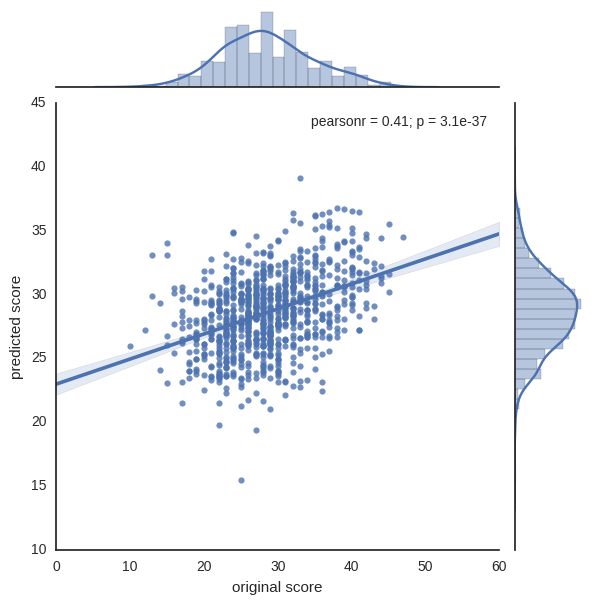

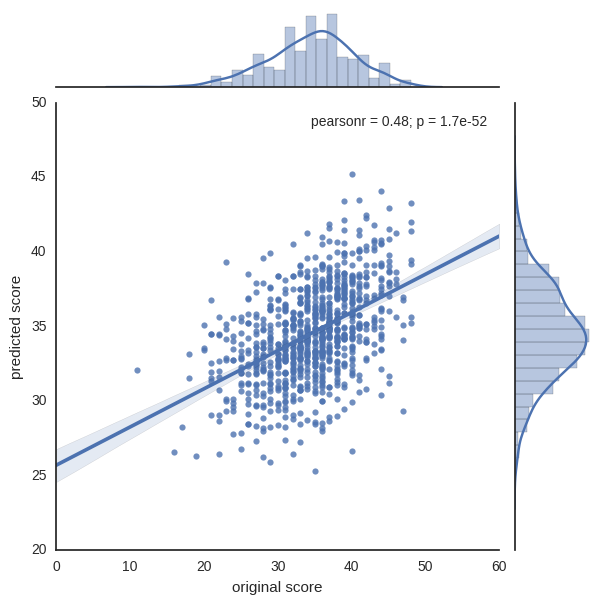

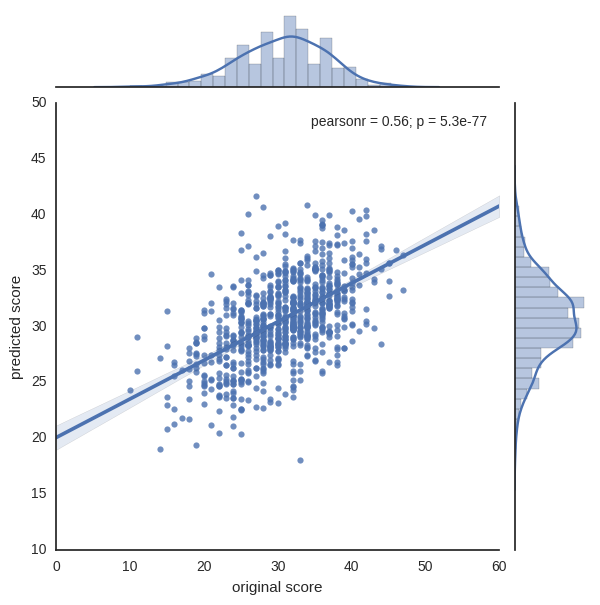

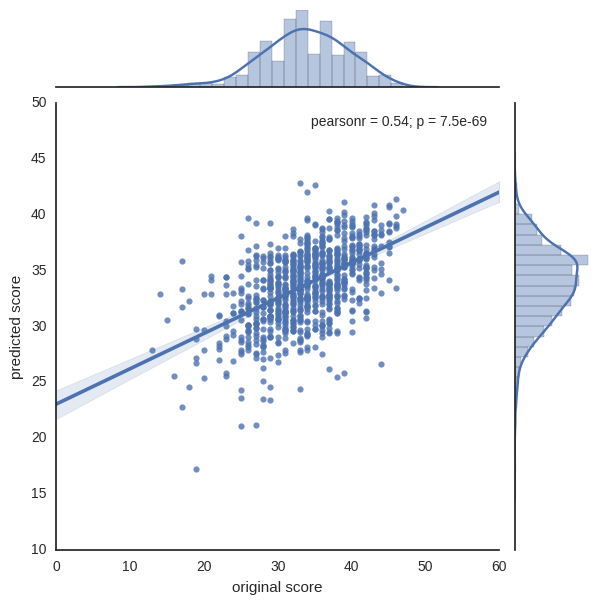

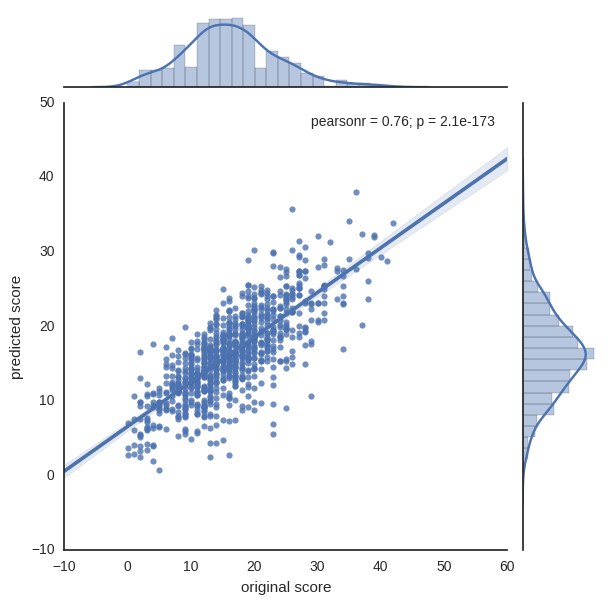

In [23]:
detectOutliers = False

# all measures under cognition & emotion category 
# described in HCP docu are used as predictors
# note that not all variables of those measures are used
predictors = ['Gender','Age_in_Yrs',
              'PicSeq_Unadj','CardSort_Unadj','Flanker_Unadj','PMAT24_A_CR','ReadEng_Unadj',
              'ProcSpeed_Unadj','DDisc_AUC_200','DDisc_AUC_40K','VSPLOT_TC','SCPT_SEN','SCPT_SPEC',
              'IWRD_TOT','ListSort_Unadj','PicVocab_Unadj','ER40_CR','AngAffect_Unadj',
              'AngHostil_Unadj','AngAggr_Unadj','FearAffect_Unadj','FearSomat_Unadj','Sadness_Unadj',
              'LifeSatisf_Unadj','MeanPurp_Unadj','PosAffect_Unadj','Friendship_Unadj','Loneliness_Unadj',
              'PercHostil_Unadj','PercReject_Unadj','EmotSupp_Unadj','InstruSupp_Unadj',
              'PercStress_Unadj','SelfEff_Unadj']
# last line newly added
targets = ['NEOFAC_O','NEOFAC_C','NEOFAC_E','NEOFAC_A_corr','NEOFAC_N']


# get index for all missing value
predictors_missed_index = []
predictors_missed_index = np.array(predictors_missed_index).reshape(0,1)
for i in range(len(predictors)):
    measure = predictors[i]
    m       = np.argwhere(np.isnan(df[measure]))
    #print measure, m.T
    predictors_missed_index = np.concatenate((m,predictors_missed_index),0)
predictors_missed_index = np.unique(predictors_missed_index)
predictors_missed_index.tolist()

n_subs = df.shape[0] - len(predictors_missed_index)

# delete missing values
newdf        = df[np.logical_not(df.index.isin(predictors_missed_index))]
newdf.index  = range(newdf.shape[0])

# make predictor matrix
X = np.zeros((n_subs,len(predictors)))
for i in range(len(predictors)):
    X[:,i] = newdf[predictors[i]]
print X.shape

# CROSS VALIDATED PREDICTION
# RESPECTING FAMILY STRUCTURE
dic_errors     = dict()
for target in targets:
    score = np.ravel(newdf[target])

    score_pred = np.empty(score.shape)
    for el in np.unique(newdf['Family_ID']):
        test_index  = list(newdf.ix[newdf['Family_ID']==el].index)
        train_index = np.setdiff1d(np.arange(n_subs),test_index)
        rbX         = RobustScaler()
        X_train     = rbX.fit_transform(X[train_index,:])
        X_test      = rbX.transform(X[test_index,:])
        X_train     = X[train_index,:]
        X_test      = X[test_index,:]
        regr        = linear_model.LinearRegression()
        regr.fit(X_train, score[train_index])
        score_pred.flat[test_index] = regr.predict(X_test)

    sns.jointplot(score,score_pred, kind="reg").set_axis_labels("original score", "predicted score")
    
    dic_errors[target] = score - score_pred

df_errors = pd.DataFrame(dic_errors, columns=targets)
    
df_errors_absZ = df_errors.apply(stats.zscore).apply(np.abs)

# COMPUTE OUTLIER SCORE
stdThr = 2.3
outlierScore = np.zeros(score.shape)
for target in targets:
    outlierScore = outlierScore + (np.ravel(df_errors_absZ[target])>stdThr)*1

# IDENTIFY OUTLIERS
outlierScoreThr = 2
print df_errors_absZ[outlierScore>=outlierScoreThr]

if detectOutliers:
    # UPDATE DATAFRAME
    # remove subjects with missing values for any of the variables used as predictors
    df = df[np.logical_not(df.index.isin(predictors_missed_index))]
    df.index  = range(df.shape[0])
    # add a column
    df['outlierScore']=outlierScore
    # remove subjects with outlier predictions
    df = df[np.logical_not(df.index.isin(np.argwhere(outlierScore>=outlierScoreThr)))]
    df.index  = range(df.shape[0])
    np.unique(df['outlierScore'])

In [ ]:
from sklearn import manifold, decomposition
this = decomposition.FactorAnalysis(n_components=2, max_iter=1000)
# this = manifold.MDS(n_components=2, max_iter=100, n_init=1)
# this = manifold.TSNE(n_components=2, init='random')
# scoreMat2d = this.fit_transform(scoreMatScaled)
def varimax(Phi, gamma = 1., q = 20, tol = 1e-6):
    from numpy import eye, asarray, dot, sum, diag
    from numpy.linalg import svd
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in xrange(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d/d_old < tol: break
    return dot(Phi, R)

this.fit(itemMat.T)
WR = varimax(this.components_.T)
itemMat2d = np.dot(itemMat.T,WR)

# for iScore,score in enumerate(scoreL):
#     print '{0:s} : X = {1:.1f}, Y = {2:.1f}'.format(
#         score,np.sum(np.multiply(scoreMat2d[:,0],scoreMatScaled[:,iScore])),np.sum(np.multiply(scoreMat2d[:,1],scoreMatScaled[:,iScore])))

fig = plt.figure(figsize=(10,6.6));
# ax = fig.add_subplot(331)
# plt.scatter(scoreMat2d[:, 0], scoreMat2d[:, 1],c=np.ravel(df['Gender']),cmap=plt.cm.Spectral)
# plt.title("Gender")
# plt.axis('tight')
# ax = fig.add_subplot(332)
# plt.scatter(scoreMat2d[:, 0], scoreMat2d[:, 1],c=np.ravel(df['Age_in_Yrs']),cmap=plt.cm.Spectral)
# plt.title("Age")
# plt.axis('tight')
# ax = fig.add_subplot(333)
# plt.scatter(scoreMat2d[:, 0], scoreMat2d[:, 1],c=np.ravel(df['PMAT24_A_CR']),cmap=plt.cm.Spectral)
# plt.title("PMAT24_A_CR")
# plt.axis('tight')
ax = fig.add_subplot(231)
plt.scatter(scoreMat2d[:, 0], scoreMat2d[:, 1],c=np.ravel(df['NEOFAC_O']),cmap=plt.cm.Spectral)
plt.title("Openness")
plt.axis('tight')
ax = fig.add_subplot(232)
plt.scatter(scoreMat2d[:, 0], scoreMat2d[:, 1],c=np.ravel(df['NEOFAC_C']),cmap=plt.cm.Spectral)
plt.title("Conscientiousness")
plt.axis('tight')
ax = fig.add_subplot(233)
plt.scatter(scoreMat2d[:, 0], scoreMat2d[:, 1],c=np.ravel(df['NEOFAC_E']),cmap=plt.cm.Spectral)
plt.title("Extroversion")
plt.axis('tight')
ax = fig.add_subplot(234)
plt.scatter(scoreMat2d[:, 0], scoreMat2d[:, 1],c=np.ravel(df['NEOFAC_A_corr']),cmap=plt.cm.Spectral)
plt.title("Agreeableness")
plt.axis('tight')
ax = fig.add_subplot(235)
plt.scatter(scoreMat2d[:, 0], scoreMat2d[:, 1],c=np.ravel(df['NEOFAC_N']),cmap=plt.cm.Spectral)
plt.title("Neuroticism")
plt.axis('tight')